In [1]:
import random
import re

import dill
import numpy as np
import torch
import torchaudio
from IPython.display import Audio, display
from matplotlib import pyplot as plt
from torchaudio.functional import deemphasis
from torchinfo import summary as info
from torchsummary import summary
from tqdm.notebook import tqdm

from audio_generation.tacotron_vw.model import Tacotron
from melgan.generator import Generator as MelGAN
from utils import MelSpec, lambda2str
from waveglow.waveglow import WaveGlow

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"

In [2]:
tacotron2 = torch.hub.load("NVIDIA/DeepLearningExamples:torchhub", "nvidia_tacotron2", model_math="fp32")
tacotron2 = tacotron2.to(DEVICE).eval()

Using cache found in /home/vvh413/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vvh413/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vvh413/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [3]:
texts_en = [
    "Good afternoon, we present project number fourteen seventy-nine, a study of the application of voice-tone transfer technology.",
    "The results indicate that MelGAN is comparable to some of the best performing models to date as a vocoder component of TTS pipeline.",
]
texts_ru = [
    "Добрый день, мы представляем проект номер четырнадцать семядесят девять - исследование применения технологии переноса тембра голоса",
    "Киты - морские млекопитающие из инфраотряда китообразных, не относящиеся ни к дельфинам, ни к морским свиньям.",
    "Косатка и гринды имеют слово кит в своих неофициальных названиях, хотя по строгой таксономии они являются дельфинами.",
    "В устаревшей классификации под китами подразумевали гладких китов. В старину под словом кит иногда подразумевался левиафан.",
]

In [4]:
utils = torch.hub.load("NVIDIA/DeepLearningExamples:torchhub", "nvidia_tts_utils")

Using cache found in /home/vvh413/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [5]:
import os

sorted(os.listdir("models/"))

['_b_melgan_8192_22k_400_slaney_norm_f',
 'melgan_16384_22k_100_slaney_norm_f',
 'melgan_8192_16k_100',
 'melgan_8192_22k_100_1.5pow',
 'melgan_8192_22k_160',
 'melgan_8192_22k_200_1.5pow_slaney',
 'melgan_8192_22k_80_librosa',
 'melgan_8192_24k_100_vw_2',
 'melgan_8192_24k_100_vw_aug_log10',
 'melgan_8192_24k_100_vw_aug_nonorm',
 'melgan_8192_24k_100_vw_base',
 'melgan_8192_24k_100_vw_base_nonorm',
 'melgan_8192_24k_100_vw_preemphasis_no_norm',
 'melgan_8192_24k_100_vw_preemphasis_no_norm_log10',
 'melgan_8192_24k_180_vw_preemphasis',
 'melgan_8192_24k_200_vw',
 'melgan_8192_24k_80_vw_noaug',
 'waveglow_22k_100',
 'waveglow_22k_100_bak']

In [6]:
# MODEL_TAG = "melgan_8192_24k_100_vw_base"
MODEL_TAG = "_b_melgan_8192_22k_400_slaney_norm_f"
melgan = MelGAN(80, 32, 3)
melgan.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/gen_9.pt"))
melgan = melgan.to(DEVICE).eval()

In [7]:
# summary(melgan, (80, 32), batch_size=32, device=DEVICE)

In [8]:
MODEL_TAG = "waveglow_22k_100"
waveglow = WaveGlow(80, 12, 8, 8, 256)
waveglow.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/model_6.pt"))
waveglow = waveglow.to(DEVICE).eval()
waveglow.remove_weight_norm()

In [9]:
SIGMA = 0.7

In [17]:
@torch.no_grad()
def denoise(waveglow, mel, audio, strength):
    # mel_input = torch.randn_like(mel, device=DEVICE)
    mel_input = torch.zeros_like(mel, device=DEVICE)
    bias_audio = waveglow.infer(mel_input, sigma=0.0)
    bias_spec = torch.stft(bias_audio, 1024, 256, 1024, return_complex=True)
    audio_spec = torch.stft(audio, 1024, 256, 1024, return_complex=True)
    denoised = audio_spec.abs() - bias_spec.abs() * strength
    denoised = torch.clamp(denoised, 0.0)
    denoised = torch.polar(denoised, audio_spec.angle())
    return torch.istft(denoised, 1024, 256, 1024, return_complex=False)

  0%|          | 0/1 [00:00<?, ?it/s]

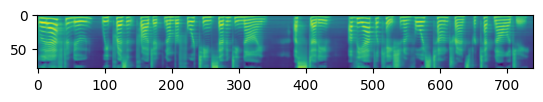

In [20]:
for i, text in enumerate(tqdm(texts_en[:1])):
    sequences, lengths = utils.prepare_input_sequence([text], cpu_run=DEVICE == "cpu")
    with torch.no_grad():
        mel, _, _ = tacotron2.infer(sequences, lengths)
        # audio = melgan(mel)
        audio = waveglow.infer(mel, sigma=SIGMA)
        audio = denoise(waveglow, mel, audio, 1)
    audio_numpy = audio[0].data.cpu().numpy()
    rate = 22050

    plt.subplot(len(texts_en), 1, i + 1)
    plt.imshow(mel.cpu()[0])

    display(Audio(audio_numpy, rate=rate))

    torchaudio.save(f"test_de.wav", audio.cpu(), rate)

In [125]:
MODEL_TAG = "melgan_8192_24k_180_vw_preemphasis"
# MODEL_TAG = "_b_melgan_8192_22k_400_slaney_norm_f"
gen = Generator(80, 32, 3)
gen.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/gen_9.pt"))
gen = gen.to(DEVICE).eval()

In [126]:
tacotron_vw = Tacotron(38)
tacotron_vw.load_state_dict(torch.load("audio_generation/tacotron_vw.pt"))
tacotron_vw = tacotron_vw.to(DEVICE)

In [127]:
VOCAB = np.array(
    [
        " ",
        "!",
        ",",
        "-",
        ".",
        "?",
        "а",
        "б",
        "в",
        "г",
        "д",
        "е",
        "ж",
        "з",
        "и",
        "й",
        "к",
        "л",
        "м",
        "н",
        "о",
        "п",
        "р",
        "с",
        "т",
        "у",
        "ф",
        "х",
        "ц",
        "ч",
        "ш",
        "щ",
        "ъ",
        "ы",
        "ь",
        "э",
        "ю",
        "я",
    ],
    dtype="<U1",
)


def transform_single_text(text):
    text = text.lower()
    text = re.sub("[^А-я \!\?\.\,\-]+", "", text)
    temp_res = []
    for letter in text:
        index = np.where(VOCAB == letter)[0][0]
        temp_res.append(index)
    return temp_res


def code_text(text):
    text = transform_single_text(text)
    text = torch.tensor(text).unsqueeze(0)
    return text

In [128]:
text = texts_ru[0]
seq = code_text(text).to(DEVICE)
seq

tensor([[10, 20,  7, 22, 33, 15,  0, 10, 11, 19, 34,  2,  0, 18, 33,  0, 21, 22,
         11, 10, 23, 24,  6,  8, 17, 37, 11, 18,  0, 21, 22, 20, 11, 16, 24,  0,
         19, 20, 18, 11, 22,  0, 29, 11, 24, 33, 22, 19,  6, 10, 28,  6, 24, 34,
          0, 23, 11, 18, 37, 10, 11, 23, 37, 24,  0, 10, 11,  8, 37, 24, 34,  0,
          3,  0, 14, 23, 23, 17, 11, 10, 20,  8,  6, 19, 14, 11,  0, 21, 22, 14,
         18, 11, 19, 11, 19, 14, 37,  0, 24, 11, 27, 19, 20, 17, 20,  9, 14, 14,
          0, 21, 11, 22, 11, 19, 20, 23,  6,  0, 24, 11, 18,  7, 22,  6,  0,  9,
         20, 17, 20, 23,  6]], device='cuda:0')

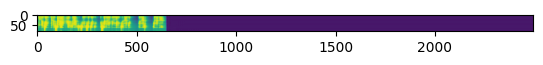

In [129]:
with torch.no_grad():
    mel, spec = tacotron_vw.predict(seq)
    # mel = torch.nn.functional.relu(mel)
    # mel = (mel * 100) - 100
    # mel = mel * 0.05
    # mel = torch.pow(10, mel * 0.05)
    # mel = torch.log(mel)
    audio = gen(mel)
    audio = deemphasis(audio)

plt.imshow(mel.cpu()[0])
display(Audio(audio[0].data.cpu().numpy(), rate=24000))
torchaudio.save(f"test.wav", audio[0].cpu(), 24000)

In [115]:
def reconstruct_audio(spec):
    spec = (torch.clip(spec, 0, 1) * 100) - 80
    spec = torch.pow(10, spec * 0.05)
    transform = torchaudio.transforms.GriffinLim(
        n_fft=2048, win_length=int(24000 * 0.05), hop_length=int(24000 * 0.0125), power=1.2
    ).to(DEVICE)
    # print(spec.mean(), spec.min(), spec.max())
    waveform = transform(spec.transpose(1, 2)).detach()
    waveform = deemphasis(waveform)
    return waveform

In [79]:
# def reconstruct_audio(mel):
#     mel = (torch.clip(mel, 0, 1) * 100) - 100
#     mel = torch.pow(10, mel * 0.05)
#     transform = torchaudio.transforms.InverseMelScale(sample_rate=24000, n_stft=1025, n_mels=80).to(DEVICE)
#     spec = transform(mel)
#     transform = torchaudio.transforms.GriffinLim(n_fft=2048, win_length=int(24000*0.05), hop_length=int(24000*0.0125), power=1.2).to(DEVICE)
#     waveform = transform(spec).detach()
#     waveform = deemphasis(waveform)
#     return waveform

In [80]:
torchaudio.__version__

'2.0.1+cu117'

In [130]:
audio = reconstruct_audio(spec)[0].cpu()
display(Audio(audio, rate=24000))
# torchaudio.save(f"test.wav", audio[None], 24000)

In [47]:
SAMPLE_RATE = 24000
SEQ_LENGTH = 8192
N_FFT = 2048
WIN_LEN = int(SAMPLE_RATE * 0.05)
HOP_LEN = int(SAMPLE_RATE * 0.0125)
PAD = 640
MEL_SPEC_CONF = dict(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    win_length=WIN_LEN,
    hop_length=HOP_LEN,
    n_mels=80,
    f_min=40,
    f_max=8000,
    power=1.2,
    pad=PAD,
    # log_fn=lambda x: torch.log10(x),
    log_fn=lambda x: 20 * torch.log10(x),
    norm_fn=lambda x: torch.clamp((x + 100) / 100, 0),
)

In [17]:
MEL_SPEC_CONF = dill.load(open(f"models/{MODEL_TAG}/mel_spec_conf", "rb"))

In [48]:
mel_feat = MelSpec(MEL_SPEC_CONF).to(DEVICE)
# print(lambda2str(mel_feat.conf.get("log_fn", torch.log)))
# print(lambda2str(mel_feat.conf.get("norm_fn", None)))
mel_feat.conf

{'sample_rate': 24000,
 'n_fft': 2048,
 'win_length': 1200,
 'hop_length': 300,
 'n_mels': 80,
 'f_min': 40,
 'f_max': 8000,
 'power': 1.2,
 'pad': 640,
 'log_fn': <function __main__.<lambda>(x)>,
 'norm_fn': <function __main__.<lambda>(x)>}

In [49]:
from dataset.dataset import AudioDataset

dataset_val = AudioDataset("dataset/russian-open-stt/audio_dataset/audio_files", 24000)

In [50]:
def wav2mel(wav):
    spectrogram_transform = torchaudio.transforms.Spectrogram(
        n_fft=2048, win_length=int(24000 * 0.05), hop_length=int(24000 * 0.0125), power=1.2
    ).to(DEVICE)
    spectrogram = spectrogram_transform(wav)
    mel_transform = torchaudio.transforms.MelScale(n_mels=80, sample_rate=24000, n_stft=2048 // 2 + 1).to(DEVICE)
    new_mel = mel_transform(spectrogram.abs())

    # print(spectrogram.mean(), spectrogram.min(), spectrogram.max())
    print(new_mel.mean(), new_mel.std(), new_mel.min(), new_mel.max())

    ### Амплитуда в децибелы
    spectrogram = 20 * torch.log10(torch.clamp(spectrogram.abs(), min=1e-5))
    new_mel = 20 * torch.log10(torch.clamp(new_mel, min=1e-5))

    # print(spectrogram.mean(), spectrogram.min(), spectrogram.max())
    print(new_mel.mean(), new_mel.std(), new_mel.min(), new_mel.max())

    ### Нормализация
    spectrogram = torch.clamp((spectrogram + 80) / 100, 0, 1)

    new_mel = (new_mel + 100) / 100
    print(new_mel.mean(), new_mel.std(), new_mel.min(), new_mel.max())
    new_mel = new_mel.clamp(0, 2)
    print(new_mel.mean(), new_mel.std(), new_mel.min(), new_mel.max())

    # print(spectrogram.mean(), spectrogram.min(), spectrogram.max())

    return new_mel, spectrogram

In [55]:
from torchaudio.functional import deemphasis, preemphasis

audio = random.choice(dataset_val).to(DEVICE)
display(Audio(audio.cpu(), rate=24000))

# audio = preemphasis(audio)

mel, _ = wav2mel(audio)

mel = (mel * 100) - 100
# mel = torch.pow(10, mel * 0.05)

audio_fake = gen(mel)
# audio_fake = deemphasis(audio_fake)
display(Audio(audio_fake.detach().cpu()[0], rate=24000))

mel2 = mel_feat(audio)
mel2 = (mel2 * 100) - 100

audio_fake2 = gen(mel2)
# audio_fake3 = gen(mel3)
# audio_fake2 = deemphasis(audio_fake2)
display(Audio(audio_fake2.detach().cpu()[0], rate=24000))
# display(Audio(audio_fake3.detach().cpu()[0], rate=24000))

tensor(7.5315) tensor(23.3967) tensor(0.) tensor(668.1320)
tensor(-4.6396) tensor(25.6108) tensor(-100.) tensor(56.4972)
tensor(0.9536) tensor(0.2561) tensor(0.) tensor(1.5650)
tensor(0.9536) tensor(0.2561) tensor(0.) tensor(1.5650)


In [13]:
from espnet2.bin.tts_inference import Text2Speech

lang = "English"
# model_name = 'kan-bayashi/vctk_gst_transformer'
vocoder_tag = "none"
model_name = "kan-bayashi/ljspeech_transformer"
text2speech = Text2Speech.from_pretrained(model_name, device="cuda")

In [18]:
out = text2speech(texts[0])

In [19]:
out["feat_gen"].transpose(0, 1).size()

torch.Size([80, 833])

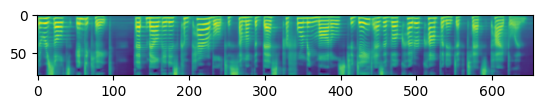

In [21]:
audio = gen(out["feat_gen"].transpose(0, 1))

audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

# plt.subplot(audio.size(0), 1, i + 1)
plt.imshow(mel.cpu()[0])
display(Audio(audio_numpy, rate=rate))
# torchaudio.save("test.wav", audio.cpu() * 128, rate)

In [21]:
mel.size()

torch.Size([1, 80, 676])

In [14]:
%%time
import torchaudio

invers_transform = torchaudio.transforms.InverseMelScale(
    sample_rate=24000,
    n_stft=1025,
    n_mels=80,
    # f_max=8000.0,
    # mel_scale="slaney"
).cuda()
grifflim_transform = torchaudio.transforms.GriffinLim(
    n_fft=2048, n_iter=100, win_length=1200, hop_length=300, power=1.2
).cuda()

# spec = invers_transform(out["feat_gen"].transpose(0, 1))
# spec = invers_transform(torch.exp(mel))
spec = invers_transform(mel)
print(spec.size())
wav = grifflim_transform(spec)
print(wav.size())
display(Audio(wav.cpu(), rate=24000))

torch.Size([1, 1025, 2495])
torch.Size([1, 748200])


CPU times: user 42.9 s, sys: 375 ms, total: 43.3 s
Wall time: 43.7 s


In [30]:
torchaudio.save("test.wav", wav.cpu(), rate, encoding="PCM_F")

In [24]:
from TTS.api import TTS

TTS.list_models()

['tts_models/multilingual/multi-dataset/your_tts',
 'tts_models/bg/cv/vits',
 'tts_models/cs/cv/vits',
 'tts_models/da/cv/vits',
 'tts_models/et/cv/vits',
 'tts_models/ga/cv/vits',
 'tts_models/en/ek1/tacotron2',
 'tts_models/en/ljspeech/tacotron2-DDC',
 'tts_models/en/ljspeech/tacotron2-DDC_ph',
 'tts_models/en/ljspeech/glow-tts',
 'tts_models/en/ljspeech/speedy-speech',
 'tts_models/en/ljspeech/tacotron2-DCA',
 'tts_models/en/ljspeech/vits',
 'tts_models/en/ljspeech/vits--neon',
 'tts_models/en/ljspeech/fast_pitch',
 'tts_models/en/ljspeech/overflow',
 'tts_models/en/ljspeech/neural_hmm',
 'tts_models/en/vctk/vits',
 'tts_models/en/vctk/fast_pitch',
 'tts_models/en/sam/tacotron-DDC',
 'tts_models/en/blizzard2013/capacitron-t2-c50',
 'tts_models/en/blizzard2013/capacitron-t2-c150_v2',
 'tts_models/es/mai/tacotron2-DDC',
 'tts_models/es/css10/vits',
 'tts_models/fr/mai/tacotron2-DDC',
 'tts_models/fr/css10/vits',
 'tts_models/uk/mai/glow-tts',
 'tts_models/uk/mai/vits',
 'tts_models/zh

In [25]:
overflow = "tts_models/en/ljspeech/overflow"
speedyspeech = "tts_models/en/ljspeech/speedy-speech"
fast_pitch = "tts_models/en/ljspeech/fast_pitch"

In [26]:
tts = TTS(model_name=fast_pitch, progress_bar=True, gpu=True)

 > tts_models/en/ljspeech/fast_pitch is already downloaded.
 > vocoder_models/en/ljspeech/hifigan_v2 is already downloaded.
 > Using model: fast_pitch
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Vocoder Model: hifigan
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resam

In [28]:
Audio(tts.tts(texts_en[0]), rate=22050)

 > Text splitted to sentences.
['The results indicate that MelGAN is comparable to some of the best performing models to date as a vocoder component of TTS pipeline.']
 > Processing time: 0.3212409019470215
 > Real-time factor: 0.03998104560604524


In [29]:
tts_model = tts.synthesizer.tts_model

In [30]:
import numpy as np

text_inputs = (
    torch.tensor(
        np.asarray(
            tts_model.tokenizer.text_to_ids(texts_en[0], language=None),
            dtype=np.int32,
        ),
        dtype=torch.long,
    )
    .unsqueeze(0)
    .to("cuda")
)

In [31]:
text_inputs

tensor([[ 30,  48, 129,  77,  63,  27,  91,  13,  21,  20, 129,  63,  15,   6,
          63,  12,   7,  63,  21, 129,  30,  28,  21, 129,  14,  50,  13,  55,
          48,  15, 129,  63,  27, 129,  12,  48,  14,  17,  28,  77,  48,   4,
          48,  13, 129,  21,  48, 129,  20,  91,  14, 129,  48,  23, 129,  30,
          48, 129,   4,  50,  20,  21, 129,  17,  49,   8,  43,  77,  14,  63,
          33, 129,  14,  40,   6,  48,  13,  27, 129,  21,  48, 129,   6,   7,
          63,  21, 129,  28,  27, 129,  48, 129,  23,  16,  89,  12,  16,  89,
           6,  49, 129,  12,  48,  14,  17,  16,  89,  15,  48,  15,  21, 129,
          48,  23, 129,  21,  20, 129,  17,   3,  63,  17,  13,   3,  63,  15,
         125]], device='cuda:0')

In [32]:
out = tts_model.inference(text_inputs)

In [33]:
out["model_outputs"].transpose(1, 2).size()

torch.Size([1, 80, 643])

In [38]:
audio = gen(out["model_outputs"].transpose(1, 2))

audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

# plt.subplot(audio.size(0), 1, i + 1)
plt.imshow(mel.cpu()[0])
display(Audio(audio_numpy, rate=rate))